приветствую! взял проект по классификации. мой профиль https://www.kaggle.com/nrobxam (gleb kabanov)

ссылка на гит - 

сам проект зафейлил, хотя через бенчмарк прошел. в начале потерял время на попытке сделать xgboost без вызова, как мы делали на занятии, склерна - неуспешно. 

Я был бы очень благодарен, если бы кто нибудь смог скинуть мне ссылку / скрипт как сделать его без вызова библиотек - очень много времени потерял, в инете пусто, голову сломал.

далее пробовал прописать-запустить нейронку без либ - получилось разобраться с размерностью, но точность низкая. кол-во слоев, гиперпараметры тоже не помогли. а жаль, была ставка на нее.

сделал балансировку выборки - НН тоже не взлетела.

в конце быстро запустил случайный лес - на сбалансированной выборке прошел бенчмарк.

In [0]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from google.colab import drive

In [3]:
drive.mount('/content/my_drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/my_drive


## data upload

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp 'my_drive/My Drive/Colab Notebooks/kaggle.json' ~/.kaggle/
!kaggle competitions download -c choose-tutors

  0% 0.00/107k [00:00<?, ?B/s]
100% 107k/107k [00:00<00:00, 41.6MB/s]
  0% 0.00/555k [00:00<?, ?B/s]
100% 555k/555k [00:00<00:00, 77.3MB/s]
  0% 0.00/547k [00:00<?, ?B/s]
100% 547k/547k [00:00<00:00, 75.5MB/s]


In [0]:
train_data = np.genfromtxt('train.csv', delimiter=',')
train_data = train_data[1:, :]
test_data = np.genfromtxt('test.csv', delimiter=',')
test_data = test_data[1:, :]

In [0]:
x = train_data[:,:-1]
y = train_data[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [8]:
print(train_data[np.where(train_data[:, -1]== 1)].shape)
print(train_data[np.where(train_data[:, -1]== 0)].shape)

(1109, 13)
(8891, 13)


# случайный лес

In [0]:
def get_bootstrap(data, labels, n):
    n_samples = data.shape[0]
    bootstrap = []

    # by rows in the sample
    for i in range(n):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        # by columns in the sample 
        for j in range(n_samples):
            # shuffling index by random
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))

    return bootstrap

def get_subsample(len_sample):
    # list of indixes from zero to len
    sample_indices = [i for i in range(len_sample)]
    # length of subsample as sqr root of the whole length
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    # shuffling the indices of the sample
    random.shuffle(sample_indices)

    for i in range(len_subsample):
        subsample.append(sample_indices.pop())

    return subsample

class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index # index of the feature comapred to threshold
        self.t = t # threshold value
        self.true_branch = true_branch # subsample in compliance with the condition in the node
        self.false_branch = false_branch # subsample not in compliance with the condition in the node

# base case node == leaf
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # qaunt of the objects of various classes
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        prediction = max(classes, key=classes.get)

        return prediction

def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

# calc the quality 
def quality(left_labels, right_labels, current_gini):
    # samples elements in the left subtree
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# splitting dataset in the node
def split(data, labels, index, t):

    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

def find_best_split(data, labels):

    # min quant of objects in the node
    min_leaf = 1

    current_gini = gini(labels)

    best_quality, best_t, best_index = 0, None, None

    n_features = data.shape[1]

    # subsample size = sq root of the sample size
    subsample = get_subsample(n_features)

    for index in subsample:
        # getting only unique values of a feature
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            # skipping splits with less than 5 objects within
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)

            # getting threshold with the max increase in quality
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)

    # base case if not quality increase
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # building true & false subtrees recursively
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

# building random forest
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)

    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))

    return forest

# classification function
def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# prediction for the sample by one tree
def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)

    return classes

# prediction by trees' vote
def tree_vote(forest, data):

    # all prediction in a list
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

    # list with predictions for the each of the objects
    predictions_per_object = list(zip(*predictions))

    # the preidction with the most of votes
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))

    return voted_predictions

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


In [19]:
# testing various quantity of trees
trees_quant = [5, 7, 10, 13, 15, 20]
for tree_numb in trees_quant:
    my_model = random_forest(x_train, y_train, tree_numb)
    train_answers = tree_vote(my_model, x_train)
    print(tree_numb,':')
    print(f'accuracy @train: {accuracy_metric(y_test, train_answers)}')
    y_pred = tree_vote(my_model, x_test)
    print(f'accuracy @test: {accuracy_metric(y_test, y_pred)}')

5 :
accuracy @train: 82.15
accuracy @test: 88.5
7 :
accuracy @train: 83.35000000000001
accuracy @test: 89.35
10 :
accuracy @train: 83.5
accuracy @test: 89.14999999999999
13 :
accuracy @train: 82.19999999999999
accuracy @test: 89.2
15 :
accuracy @train: 82.65
accuracy @test: 88.94999999999999
20 :
accuracy @train: 82.75
accuracy @test: 89.1


In [24]:
# predicting with the optimal number of tree
my_model = random_forest(x, y, 10)

train_answers = tree_vote(my_model, x_train)
print(f'@test: {accuracy_metric(y_test, y_pred)}')

y_pred = tree_vote(my_model, test_data)

@train: 89.3


In [0]:
# saving file to submission
np.savetxt(
    'submission_example.csv',
    np.column_stack((np.array(range(10000,20000)), np.array(y_pred))),
    delimiter=',',
    header='Id,choose',
    comments='',
    fmt='%d'
)

In [61]:
# checking the submission file
!head submission_example.csv

Id,choose
10000,0
10001,0
10002,0
10003,0
10004,0
10005,0
10006,0
10007,0
10008,0


In [62]:
# making submit
!kaggle competitions submit choose-tutors -f submission_example.csv -m "random forest, balanced"

100% 78.1k/78.1k [00:02<00:00, 28.4kB/s]
Successfully submitted to Choose tutors

In [13]:
# now balancing the samples

np.random.seed(1)

def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

balanced_samples = balanced_subsample(x_train, y_train)

print(f'positive target: {len(np.where(balanced_samples[-1] == 1)[0])}')
print(f'negative target: {len(np.where(balanced_samples[-1] == 0)[0])}')

IndexError: ignored

In [0]:
x_train = balanced_samples[0]
y_train = balanced_samples[1]

In [66]:
my_model = random_forest(x_train, y_train, 10)

y_pred = tree_vote(my_model, x_test)

print(f'@test: {accuracy_metric(y_test, y_pred)}')

@test: 74.45


In [67]:
# predicting with the optimal number of tree
my_model = random_forest(x_train, y_train, 10)

print(f'@test: {accuracy_metric(y_test, y_pred)}')

y_pred = tree_vote(my_model, test_data)

np.savetxt(
    'submission_example.csv',
    np.column_stack((np.array(range(10000,20000)), np.array(y_pred))),
    delimiter=',',
    header='Id,choose',
    comments='',
    fmt='%d'
)

!kaggle competitions submit choose-tutors -f submission_example.csv -m "random forest, unbalanced, using only x_train"

@test: 74.45
100% 78.1k/78.1k [00:03<00:00, 26.0kB/s]
Successfully submitted to Choose tutors

# самописная корявая нейронка

In [0]:
# functions to be used

nn_architecture = [
    {"layer_size": 12, "activation": "none"}, # input layer
    {"layer_size": 12, "activation": "relu"},
    # {"layer_size": 12, "activation": "relu"},
    # {"layer_size": 12, "activation": "relu"},
    {"layer_size": 1, "activation": "sigmoid"}
]

def initialize_parameters(nn_architecture, seed = 3):
    np.random.seed(seed)
    # python dictionary containing our parameters "W1", "b1", ..., "WL", "bL"
    parameters = {}
    number_of_layers = len(nn_architecture)

    for l in range(1, number_of_layers):
        parameters['W' + str(l)] = np.random.randn(
            nn_architecture[l]["layer_size"],
            nn_architecture[l-1]["layer_size"]
            ) * 0.01
        parameters['b' + str(l)] = np.zeros((nn_architecture[l]["layer_size"], 1))
        
    return parameters

def sigmoid(Z):
    S = 1 / (1 + np.exp(-Z))
    return S

def relu(Z):
    R = np.maximum(0, Z)
    return R

def sigmoid_backward(dA, Z):
    S = sigmoid(Z)
    dS = S * (1 - S)
    return dA * dS

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

def L_model_forward(X, parameters, nn_architecture):
    forward_cache = {}
    A = X
    number_of_layers = len(nn_architecture)
    
    for l in range(1, number_of_layers):
        A_prev = A 
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        activation = nn_architecture[l]["activation"]
        Z, A = linear_activation_forward(A_prev, W, b, activation)
        forward_cache['Z' + str(l)] = Z
        forward_cache['A' + str(l-1)] = A

    AL = A
            
    return AL, forward_cache

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z = linear_forward(A_prev, W, b)
        A = sigmoid(Z)
    elif activation == "relu":
        Z = linear_forward(A_prev, W, b)
        A = relu(Z)

    return Z, A

def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    return Z


def compute_cost(AL, Y):
    m = Y.shape[1]

    # Compute loss from AL and y
    logprobs = np.multiply(np.log(AL),Y) + np.multiply(1 - Y, np.log(1 - AL))
    # cross-entropy cost
    cost = - np.sum(logprobs) / m

    cost = np.squeeze(cost)
    
    return cost

def L_model_backward(AL, Y, parameters, forward_cache, nn_architecture):
    grads = {}
    number_of_layers = len(nn_architecture)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    dA_prev = dAL

    for l in reversed(range(1, number_of_layers)):
        dA_curr = dA_prev

        activation = nn_architecture[l]["activation"]
        W_curr = parameters['W' + str(l)]
        Z_curr = forward_cache['Z' + str(l)]
        A_prev = forward_cache['A' + str(l-1)]

        dA_prev, dW_curr, db_curr = linear_activation_backward(dA_curr, Z_curr, A_prev, W_curr, activation)

        grads["dW" + str(l)] = dW_curr
        grads["db" + str(l)] = db_curr

    return grads

def linear_activation_backward(dA, Z, A_prev, W, activation):
    if activation == "relu":
        dZ = relu_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, A_prev, W)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, A_prev, W)

    return dA_prev, dW, db

def linear_backward(dZ, A_prev, W):
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

def L_layer_model(X, Y, nn_architecture, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    # keep track of cost
    costs = []
    
    # Parameters initialization.
    parameters = initialize_parameters(nn_architecture)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, forward_cache = L_model_forward(X, parameters, nn_architecture)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, parameters, forward_cache, nn_architecture)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" %(i, cost))

        costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [0]:
# converting the samples to feed to NN

x_train = x_train.reshape(x_train.shape[1], x_train.shape[0])
y_train = y_train.reshape(1, y_train.shape[0])
x_test = x_test.reshape(x_test.shape[1], x_test.shape[0])

Cost after iteration 0: 0.711118
Cost after iteration 100: 0.572017


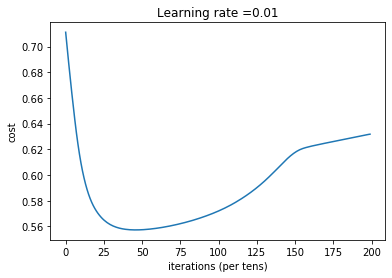

In [74]:
model = L_layer_model(x_train, y_train, nn_architecture, learning_rate = 0.01, num_iterations = 200, print_cost=True)

In [0]:
# predicting for the validation test
y_pred = L_model_forward(x_test, model, nn_architecture)

# inverse transform the predictions to the initial shape
y_pred = y_pred[0].reshape(y_pred[0].shape[1],)

In [0]:
# assuming i got probabilites
# having no additional info, i assume the threshold of 0.5

thresh = 0.5
y_pred[y_pred > thresh] = 1
y_pred[y_pred <= thresh] = 0

In [92]:
# checking metric
print(f'@test: {accuracy_metric(y_test, y_pred)}')

@test: 76.0


In [0]:
## now predict for the test data

# converting train and test data to feed into NN
test_data = test_data.reshape(test_data.shape[1], test_data.shape[0])
x = x.reshape(x.shape[1], x.shape[0])
y = y.reshape(1, y.shape[0])

Cost after iteration 0: 0.707051
Cost after iteration 100: 0.552950


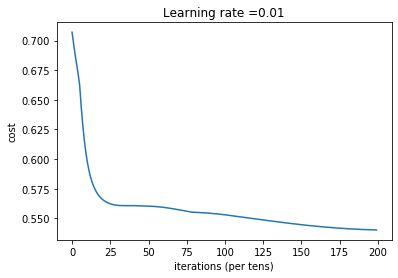

In [105]:
# training the NN
model = L_layer_model(
    x, y, 
    nn_architecture, 
    learning_rate = 0.01, 
    num_iterations = 200, 
    print_cost=True
)

In [110]:
y_pred = L_model_forward(test_data, model, nn_architecture)

y_pred = y_pred[0].reshape(y_pred[0].shape[1],)

thresh = 0.5
y_pred[y_pred > thresh] = 1
y_pred[y_pred <= thresh] = 0

print(f'@test: {accuracy_metric(y_test, y_pred)}')

@test: 86.45


In [113]:
np.savetxt(
    'submission_example.csv',
    np.column_stack((np.array(range(10000,20000)), np.array(y_pred))),
    delimiter=',',
    header='Id,choose',
    comments='',
    fmt='%d'
)

!kaggle competitions submit choose-tutors -f submission_example.csv -m "NN, unbalanced"

100% 78.1k/78.1k [00:02<00:00, 28.4kB/s]
Successfully submitted to Choose tutors

In [17]:
# now balancing the samples

balanced_samples = balanced_subsample(x_train, y_train)

print(f'positive target: {len(np.where(balanced_samples[-1] == 1)[0])}')
print(f'negative target: {len(np.where(balanced_samples[-1] == 0)[0])}')

x_train = balanced_samples[0]
y_train = balanced_samples[1]

x_train = x_train.reshape(x_train.shape[1], x_train.shape[0])
y_train = y_train.reshape(1, y_train.shape[0])
x_test = x_test.reshape(x_test.shape[1], x_test.shape[0])

positive target: 921
negative target: 921


In [0]:
# minor update to verbose greater step

def L_layer_model(X, Y, nn_architecture, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    # keep track of cost
    costs = []
    
    # Parameters initialization.
    parameters = initialize_parameters(nn_architecture)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, forward_cache = L_model_forward(X, parameters, nn_architecture)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, parameters, forward_cache, nn_architecture)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 1000 == 0:
            print("Cost after iteration %i: %f" %(i, cost))

        costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [0]:
nn_architecture = [
    {"layer_size": 12, "activation": "none"}, # input layer
    {"layer_size": 12, "activation": "relu"},
    {"layer_size": 1, "activation": "sigmoid"}
]

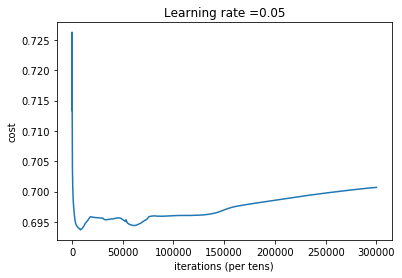

@test: 62.4


In [20]:
# training the NN - searching the optimal epochs
model = L_layer_model(
    x_train, y_train, 
    nn_architecture, 
    learning_rate = 0.05, 
    num_iterations = 300000, 
    print_cost=False
)

y_pred = L_model_forward(x_test, model, nn_architecture)

y_pred = y_pred[0].reshape(y_pred[0].shape[1],)

thresh = 0.5
y_pred[y_pred > thresh] = 1
y_pred[y_pred <= thresh] = 0

print(f'@test: {accuracy_metric(y_test, y_pred)}')

In [21]:
test_data = test_data.reshape(test_data.shape[1], test_data.shape[0])

y_pred = L_model_forward(test_data, model, nn_architecture)

y_pred = y_pred[0].reshape(y_pred[0].shape[1],)

thresh = 0.5
y_pred[y_pred > thresh] = 1
y_pred[y_pred <= thresh] = 0

print(f'@test: {accuracy_metric(y_test, y_pred)}')

np.savetxt(
    'submission_example.csv',
    np.column_stack((np.array(range(10000,20000)), np.array(y_pred))),
    delimiter=',',
    header='Id,choose',
    comments='',
    fmt='%d'
)

!kaggle competitions submit choose-tutors -f submission_example.csv -m "NN, balanced"

@test: 57.9
100% 78.1k/78.1k [00:10<00:00, 7.61kB/s]
Successfully submitted to Choose tutors